In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from src.model.mask_unet import UNet
from src.libs.preprocessing import DataLoader
from src.libs.postprocessing import (
    get_unet,
    invert_spectrogram,
    upsample_spectrogram,
    Spectrogram,
)

## Load model and test data

In [39]:
post_name = "20241222_124124"
model_loaded = get_unet(post_name=post_name)

In [40]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 782
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


## Listen Audio

In [41]:
file_number = 5
test_x, test_y = harmonized_data.x[file_number], harmonized_data.y[file_number]

In [42]:
Audio(test_x, rate=harmonized_data.sampling_freq)

In [43]:
Audio(test_y, rate=harmonized_data.sampling_freq)

# Utils spectrogram

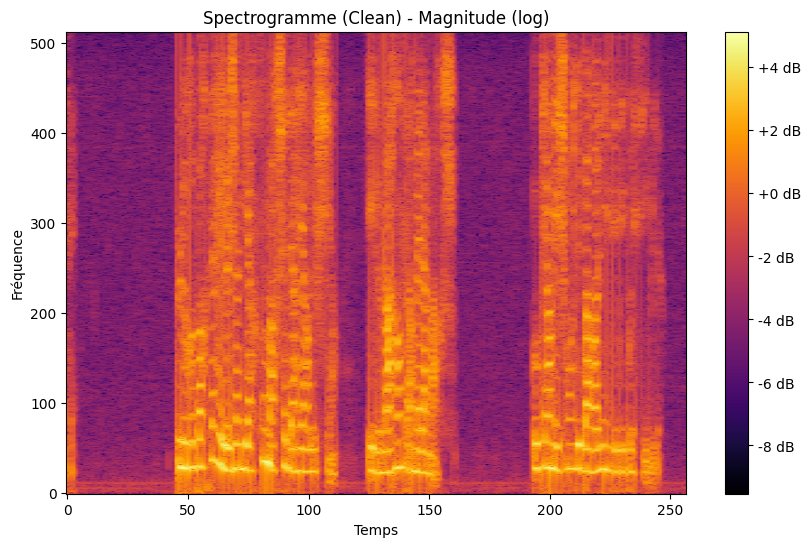

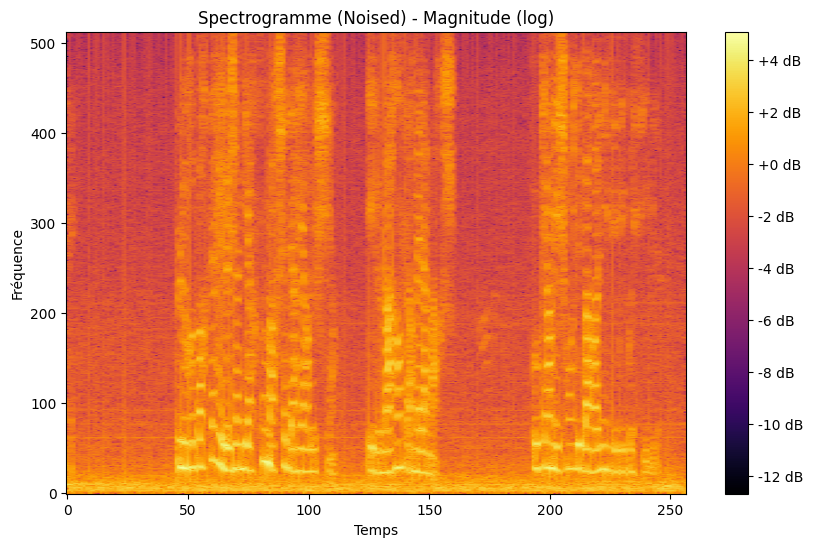

In [44]:
signal_clean = torch.tensor(test_y)
spect_clean = Spectrogram(signal_clean)

plt.figure(figsize=(10, 6))
plt.imshow(spect_clean.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower")
plt.title("Spectrogramme (Clean) - Magnitude (log)")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.show()

signal_noised = torch.tensor(test_x)
spect_noised = Spectrogram(signal_noised)

plt.figure(figsize=(10, 6))
plt.imshow(
    spect_noised.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower"
)
plt.title("Spectrogramme (Noised) - Magnitude (log)")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.show()

# Invert a spectrogram without downsample and upsample

In [45]:
# Inverser le spectrogramme
reconstructed_signal = invert_spectrogram(
    spect_clean.spectrogam,
    n_fft=spect_clean.n_fft,
    hop_length=spect_clean.hop_length,
    win_length=spect_clean.win_length,
    length=spect_clean.signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal.shape}")

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal.numpy(), rate=8000)

Reconstructed Signal Shape: torch.Size([80000])


In [46]:
(reconstructed_signal - test_y).abs().max()

/tmp/ipykernel_19651/3668745538.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (reconstructed_signal - test_y).abs().max()


tensor(5.5511e-16, dtype=torch.float64)

# Upsample Spectrogram and inversion

In [47]:
spectrogram_downsampled = spect_clean.spectrogam[:-1, :-1]

spectrogram_aug = upsample_spectrogram(spectrogram_downsampled)
print(spectrogram_aug.shape, spectrogram_downsampled.shape)
reconstructed_signal_downsampled = invert_spectrogram(
    spectrogram_aug,
    n_fft=spect_clean.n_fft,
    hop_length=spect_clean.hop_length,
    win_length=spect_clean.win_length,
    length=spect_clean.signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal_downsampled.shape}")

print((reconstructed_signal_downsampled - reconstructed_signal).abs().std())

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal_downsampled.numpy(), rate=8000)

torch.Size([513, 257]) torch.Size([512, 256])
Reconstructed Signal Shape: torch.Size([80000])
tensor(0.0003, dtype=torch.float64)


## Test pipeline example

In [48]:
post_name = "20241221_084543"
model_loaded = get_unet(post_name=post_name)

In [49]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 782
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


In [50]:
file_number = 2
test_x, test_y = harmonized_data.x[file_number], harmonized_data.y[file_number]

In [51]:
spectrogram_noised = Spectrogram(torch.tensor(test_x))
mask = model_loaded(spectrogram_noised.magnitude[:-1, :-1].float()[None, None, :])
denoised_output = mask * spectrogram_noised.magnitude[:-1, :-1]
denoised_output_upsample = upsample_spectrogram(denoised_output)
denoised_output_upsample_complex = torch.exp(
    denoised_output_upsample + 1j * spectrogram_noised.angle
)[0, 0]
denoised_signal = invert_spectrogram(
    denoised_output_upsample_complex,
    n_fft=spectrogram_noised.n_fft,
    hop_length=spectrogram_noised.hop_length,
    win_length=spectrogram_noised.win_length,
    length=spectrogram_noised.signal.shape[0],
)
Audio(denoised_signal.detach().numpy(), rate=8000)

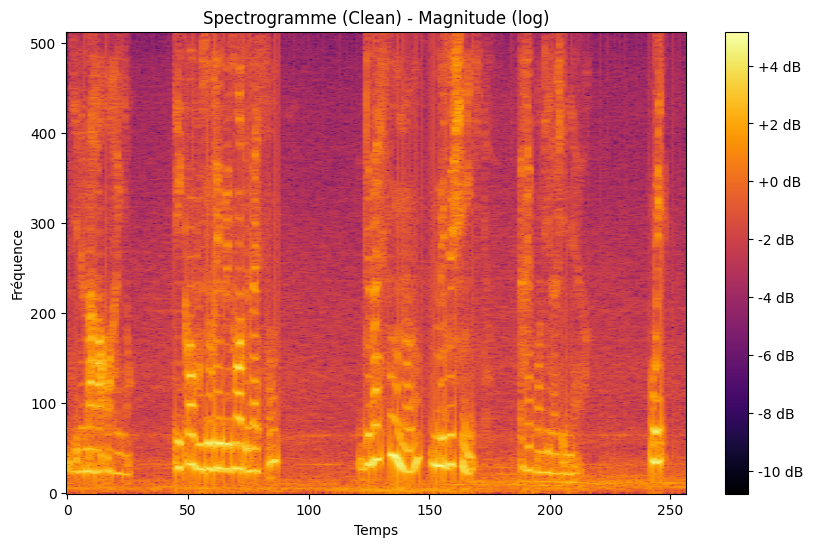

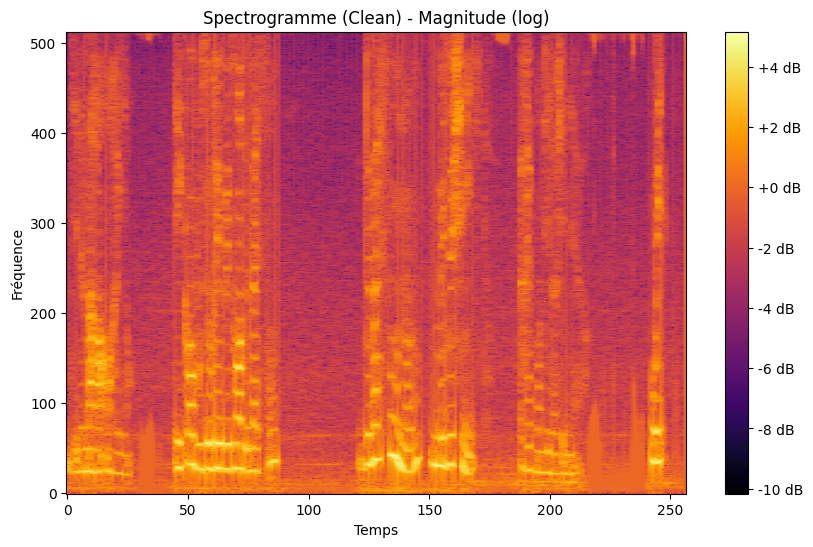

/tmp/ipykernel_19651/2446259704.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  spectrogram_noised.magnitude - denoised_output_upsample.detach()[0, 0].numpy(),


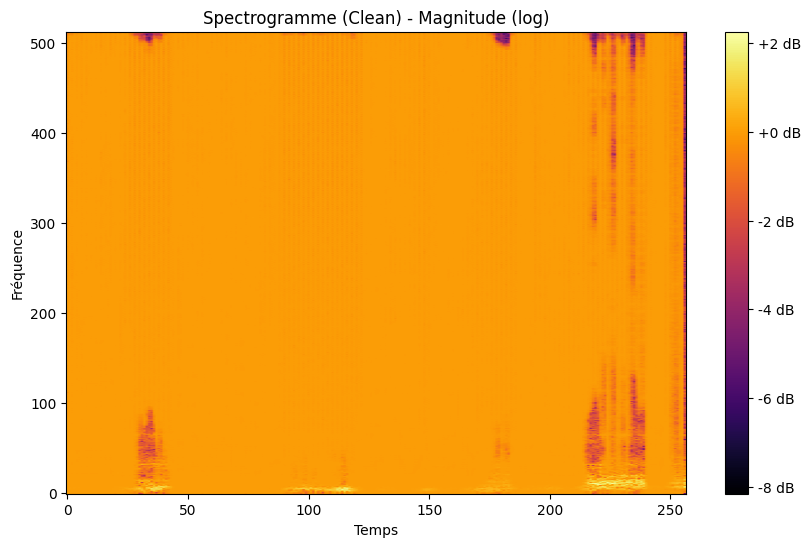

In [52]:
spectrogram_noised.plot_spectrogram()
plt.figure(figsize=(10, 6))
plt.imshow(
    denoised_output_upsample.detach()[0, 0].numpy(),
    aspect="auto",
    cmap="inferno",
    origin="lower",
)
plt.title("Spectrogramme (Clean) - Magnitude (log)")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(
    spectrogram_noised.magnitude - denoised_output_upsample.detach()[0, 0].numpy(),
    aspect="auto",
    cmap="inferno",
    origin="lower",
)
plt.title("Spectrogramme (Clean) - Magnitude (log)")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.show()